## Setup google drive and change to working directory

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
%cd "/content/drive/My Drive/github_cs230_project_mri/project_fmri/vqvae/"
!ls  #check you see folder contents main.py etc.

/content/drive/My Drive/github_cs230_project_mri/project_fmri/vqvae
datasets	   main_colab.ipynb  __pycache__       visualization.ipynb
extract_tokens.py  main.py	     requirements.txt  wandb
__init__.py	   models	     utils.py


## Load Model with Checkpoint

In [10]:
checkpoint_path = "../results/vqvae_data_mon_nov_24_12_57_54_2025.pth"

In [11]:
import importlib
import utils
importlib.reload(utils)
from utils import load_model
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(checkpoint_path, state="eval")

model.to(device)
model.eval()

VQVAE(
  (encoder): Encoder(
    (conv_stack): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResidualStack(
        (stack): ModuleList(
          (0-1): 2 x ResidualLayer(
            (res_block): Sequential(
              (0): ReLU(inplace=True)
              (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (2): ReLU(inplace=True)
              (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
        )
      )
    )
  )
  (pre_quantization_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (vector_quantization): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (inverse_conv_stack): Sequential(
      (0): Con

## Extract Tokens for Train/Val/Test and Save

In [12]:
train_data_path = "../data/train/train_data.npy"
val_data_path = "../data/val/val_data.npy"
test_data_path = "../data/test/test_data.npy"

In [13]:
import os
import numpy as np
import torch

def data_path_to_tokens_path(data_path: str) -> str:
    """
    Makes appropriate paths to save tokens data
    ../data/train/train_data.npy -> ../data/train/train_tokens.npy
    """
    split_dir = os.path.basename(os.path.dirname(data_path))  # "train", "val", "test"
    base_dir = os.path.dirname(data_path)                     # "../data/train"
    tokens_filename = f"{split_dir}_tokens.npy"               # "train_tokens.npy"
    return os.path.join(base_dir, tokens_filename)

import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def extract_and_save_tokens(data_path: str):
    # derive tokens_path from data_path, as before
    import os
    split_dir = os.path.basename(os.path.dirname(data_path))   # "train", "val", or "test"
    base_dir  = os.path.dirname(data_path)                     # "../data/train"
    tokens_path = os.path.join(base_dir, f"{split_dir}_tokens.npy")

    data = np.load(data_path)   # (N, 1, 256, 256)
    print(f"\nLoading {data_path}")
    print("data shape:", data.shape)

    data_t = torch.from_numpy(data).float().to(device)

    with torch.no_grad():
        # 1) get latent spatial size H', W'
        z_e = model.encoder(data_t)
        z_e = model.pre_quantization_conv(z_e)  # shape: (B, C, H', W')
        B, C, H_lat, W_lat = z_e.shape

        # 2) full forward pass to get tokens
        _, x_hat, perplexity, tokens = model(data_t)
        print("x_hat shape:", x_hat.shape)
        print("raw tokens shape:", tokens.shape)  # (B*H'*W', 1)
        print("perplexity:", perplexity)

        # 3) reshape tokens → (B, H', W')
        tokens = tokens.view(B, H_lat, W_lat, 1).squeeze(-1)   # (B, H', W')

    print("reshaped tokens shape:", tokens.shape)
    tokens_np = tokens.detach().cpu().numpy()
    np.save(tokens_path, tokens_np)
    print(f"Saved tokens to {tokens_path}")

In [14]:
# Run for train / val / test
for path in [train_data_path, val_data_path, test_data_path]:
    extract_and_save_tokens(path)


Loading ../data/train/train_data.npy
data shape: (1158, 1, 256, 256)
x_hat shape: torch.Size([1158, 1, 256, 256])
raw tokens shape: torch.Size([4743168, 1])
perplexity: tensor(7.0299)
reshaped tokens shape: torch.Size([1158, 64, 64])
Saved tokens to ../data/train/train_tokens.npy

Loading ../data/val/val_data.npy
data shape: (386, 1, 256, 256)
x_hat shape: torch.Size([386, 1, 256, 256])
raw tokens shape: torch.Size([1581056, 1])
perplexity: tensor(6.6889)
reshaped tokens shape: torch.Size([386, 64, 64])
Saved tokens to ../data/val/val_tokens.npy

Loading ../data/test/test_data.npy
data shape: (386, 1, 256, 256)
x_hat shape: torch.Size([386, 1, 256, 256])
raw tokens shape: torch.Size([1581056, 1])
perplexity: tensor(6.6749)
reshaped tokens shape: torch.Size([386, 64, 64])
Saved tokens to ../data/test/test_tokens.npy


## Train: Visualize and compare original and reconstruction side-by-side

data shape   : (1158, 1, 256, 256)
tokens shape : (1158, 64, 64)


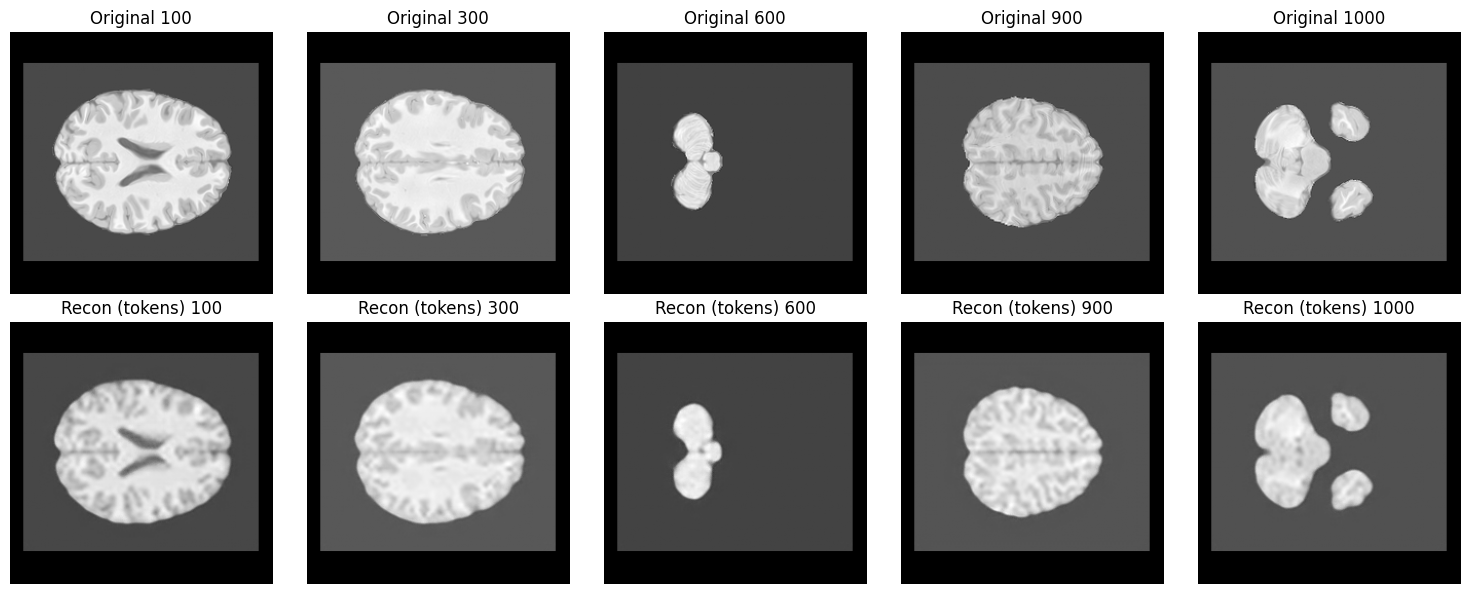

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# load original data and saved tokens
data   = np.load("../data/train/train_data.npy")        # (N, 1, 256, 256)
tokens = np.load("../data/train/train_tokens.npy")      # (N, H_lat, W_lat), e.g. (N, 64, 64)

print("data shape   :", data.shape)
print("tokens shape :", tokens.shape)

# choose the slices you want
indices = [100, 300, 600, 900, 1000]

n = len(indices)
fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))

# codebook from VQ-VAE quantizer
embedding = model.vector_quantization.embedding.weight  # (K, C)

for col, idx in enumerate(indices):
    # ---------- ORIGINAL ----------
    orig = data[idx, 0]   # (256, 256)

    # ---------- RECONSTRUCT FROM TOKENS ----------
    # tokens for this slice: (H_lat, W_lat)
    tok_grid = tokens[idx]                        # e.g. (64, 64)
    H_lat, W_lat = tok_grid.shape

    # tensor of indices
    tok_tensor = torch.from_numpy(tok_grid).long().to(device)  # (H_lat, W_lat)

    # lookup codebook: (H_lat, W_lat, C)
    z_q_grid = embedding[tok_tensor]                           # (H_lat, W_lat, C)

    # reorder to (1, C, H_lat, W_lat) for decoder
    z_q = z_q_grid.permute(2, 0, 1).unsqueeze(0)               # (1, C, H_lat, W_lat)

    with torch.no_grad():
        x_hat_from_tokens = model.decoder(z_q)                 # (1, 1, 256, 256)

    recon = x_hat_from_tokens.detach().cpu().squeeze().numpy()  # (256, 256)

    # ---------- PLOT ----------
    ax_orig = axes[0, col]
    ax_orig.imshow(orig, cmap="gray")
    ax_orig.axis("off")
    ax_orig.set_title(f"Original {idx}")

    ax_rec = axes[1, col]
    ax_rec.imshow(recon, cmap="gray")
    ax_rec.axis("off")
    ax_rec.set_title(f"Recon (tokens) {idx}")

plt.tight_layout()
plt.show()

## Validation: Visualize and compare original and reconstruction side-by-side

data shape   : (386, 1, 256, 256)
tokens shape : (386, 64, 64)


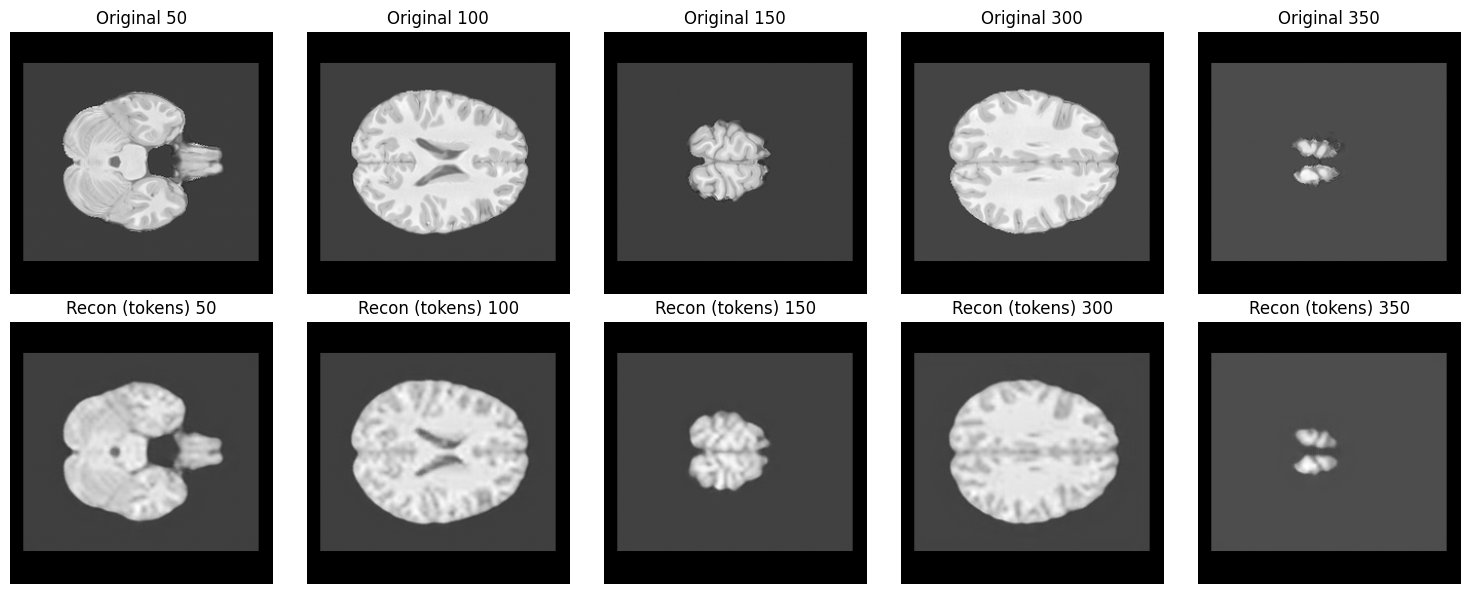

In [19]:
# Load original data and saved tokens
data   = np.load("../data/val/val_data.npy")        # (N, 1, 256, 256)
tokens = np.load("../data/val/val_tokens.npy")      # (N, H_lat, W_lat), e.g. (N, 64, 64)

print("data shape   :", data.shape)
print("tokens shape :", tokens.shape)

# choose the slices you want
indices = [50, 100, 150, 300, 350]

n = len(indices)
fig, axes = plt.subplots(2, n, figsize=(3 * n, 6))

# codebook from VQ-VAE quantizer
embedding = model.vector_quantization.embedding.weight  # (K, C)

for col, idx in enumerate(indices):
    # ---------- ORIGINAL ----------
    orig = data[idx, 0]   # (256, 256)

    # ---------- RECONSTRUCT FROM TOKENS ----------
    # tokens for this slice: (H_lat, W_lat)
    tok_grid = tokens[idx]                        # e.g. (64, 64)
    H_lat, W_lat = tok_grid.shape

    # tensor of indices
    tok_tensor = torch.from_numpy(tok_grid).long().to(device)  # (H_lat, W_lat)

    # lookup codebook: (H_lat, W_lat, C)
    z_q_grid = embedding[tok_tensor]                           # (H_lat, W_lat, C)

    # reorder to (1, C, H_lat, W_lat) for decoder
    z_q = z_q_grid.permute(2, 0, 1).unsqueeze(0)               # (1, C, H_lat, W_lat)

    with torch.no_grad():
        x_hat_from_tokens = model.decoder(z_q)                 # (1, 1, 256, 256)

    recon = x_hat_from_tokens.detach().cpu().squeeze().numpy()  # (256, 256)

    # ---------- PLOT ----------
    ax_orig = axes[0, col]
    ax_orig.imshow(orig, cmap="gray")
    ax_orig.axis("off")
    ax_orig.set_title(f"Original {idx}")

    ax_rec = axes[1, col]
    ax_rec.imshow(recon, cmap="gray")
    ax_rec.axis("off")
    ax_rec.set_title(f"Recon (tokens) {idx}")

plt.tight_layout()
plt.show()